In [69]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Caso un solo match

Para el caso de las imagenes con una sola aparicion del logo simplemente aplicamos sift para obtener los keypoints del template y del target, usamos un knn matcher y aplicamos el criterio de lowe y, con los puntos resultantes, calculamos la homografia.
Se elige SIFt por sobre ORB porque se encontro que funciona mejor para todas las imagenes y requiere un minimo preprocesamiento (sharpenning).

## Preprocesamiento:
La imagen template se preprocesa de forma tal que quede en blanco y negro. Esto permite intentar buscar un match con, por ejemplo, letras blancas y fondo negro, y, en caso de que no se detecte ninguno, negar los pixeles e intentar de nuevo con el template de letras negras y fondo blanco (util para las imagenes 'retro').
La imagen target se procesa con sharpenning.

In [175]:
def draw_homography(img1, img2, matches, kp1, kp2):
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    if M is not None:
        h,w = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv.perspectiveTransform(pts, M)
        return cv.polylines(img2, [np.int32(dst)], True, 255, 10, cv.LINE_AA)
    else:
        print("Homography could not be found.")
        return img2

def find_matching_features_sift(img1, img2):
    sift = cv.xfeatures2d.SIFT_create()
    
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    return good, kp1, kp2

def find_matching_features_orb(img1, img2):
    orb = cv.ORB_create()

    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)
    
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    return matches, kp1, kp2
    
def find_image(img1, img2):
    matches, kp1, kp2 = find_matching_features_sift(img1, img2)

    if len(matches) < 5:
        print('too few good points')
        return False
    else:
        img_keyponits = cv.drawKeypoints(img2, kp2, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(img_keyponits)
        plt.show()

        img2 = draw_homography(img1, img2, matches, kp1, kp2)
        n=30
        img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:n],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(img3)
        plt.show()       
        return True
  

# Caso multiples matches

Para el caso donde hay multiples matches se implementa el siguiente algoritmo:
1. Obtener keypoints utilizando SIFT u ORB
2. Aplicar un algoritmo de clustering (DBSCAN) sobre los keypoints de la imagen target
3. Por cada cluster aplicar un matcher
4. Con los matches dibuar el rectangulo minimo que los engloba

Aclaraciones:
1. No se calculan homografias porque las matrices que describen estas tendian a colapsar las regiones en un punto o linea. Si bien matematicamente las matrices de homografia tenian rango 3 (no eran degeneradas) se intuye que numericamente tendian a serlo. Se noto que la tercera fila contenia elementos de los ordenes de 10^-2
2. Al dibujar los rectangulos se filtran los que tengan ancho o alto menor a una cierta cantidad de pixeles.
3. Para esta aplicacion se encontro que ORB funciona bastante mejor con el preprocesamiento propuesto.

## Preprocesamiento
La imagen template se preprocesa como se explico anteriormente.
La imagen target se preprocesa aplicando un threshold estatico y luego un sharpenning.

In [151]:
def draw_rect(img, points, minsize=15):
    rect = cv.minAreaRect(points)
    box_points = cv.boxPoints(rect)
    box_points = np.intp(box_points)
    
    width, height = rect[1]
    min_dimension = min(width, height)
    if min_dimension < minsize:
        return img, False
    
    return cv.drawContours(img, [box_points], 0, 255, 5), True
    
def find_multi_image(img1, img2, debug=True, minsize=15):
    h, w = img1.shape
    
    orb = cv.ORB_create(
        nfeatures=1000,         
        scaleFactor=1.1,        
        patchSize=21,           
        fastThreshold=10,       
        WTA_K=4                 
    )
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)

    img_keyponits = cv.drawKeypoints(img2, kp2, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_keyponits)
    plt.show()

    all_points_img2 = np.float32([kp.pt for kp in kp2])
    MIN_CLUSTER_SIZE = 5
    EPSILON_DISTANCE = 15

    db = DBSCAN(eps=EPSILON_DISTANCE, min_samples=MIN_CLUSTER_SIZE).fit(all_points_img2)
    labels = db.labels_

    unique_labels = set(labels)
    num_clusters = len(unique_labels) - (1 if -1 in labels else 0)
    if debug: print(f"DBSCAN found {num_clusters} potential character clusters.")
    img_output = img2.copy()

    drawn_rects = 0
    for cluster_label in unique_labels:
        if debug: print(f'Cluster {cluster_label}')

        if cluster_label == -1:
            continue
        cluster_indices = np.where(labels == cluster_label)[0]
        cluster_kp =  np.array(kp2)[cluster_indices]
        cluster_des =  np.array(des2)[cluster_indices]
        
        bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1, cluster_des)
        matches = sorted(matches, key = lambda x:x.distance)
        if len(matches) > 4: 
            img_keyponits = cv.drawKeypoints(img2, cluster_kp, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            cluster_points = np.float32([ cluster_kp[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
            img_with_rect, drawn = draw_rect(img_keyponits, cluster_points, minsize)
            drawn_rects += drawn
            if debug:
                plt.imshow(img_with_rect)
                plt.show()
            img_output = draw_rect(img_output, cluster_points)[0]
        else:
            if debug: print("Too few good matches")
            

    if drawn_rects > 0:
        plt.imshow(img_output)
        plt.show()
    return drawn_rects

def find_multi_image_sift(img1, img2, debug=True, minsize=15):
    h, w = img1.shape
    
    sift = cv.SIFT_create(
        nfeatures=0,             # Keep all features
        nOctaveLayers=3,         # Default
        contrastThreshold=0.08,  # Lowered from 0.04 to find weaker features
        edgeThreshold=5,        # Increased from 10 to be more lenient on edges
        sigma=1.6                # Default
    )
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    img_keyponits = cv.drawKeypoints(img2, kp2, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_keyponits)
    plt.show()

    all_points_img2 = np.float32([kp.pt for kp in kp2])
    MIN_CLUSTER_SIZE = 5
    EPSILON_DISTANCE = 20

    db = DBSCAN(eps=EPSILON_DISTANCE, min_samples=MIN_CLUSTER_SIZE).fit(all_points_img2)
    labels = db.labels_

    unique_labels = set(labels)
    num_clusters = len(unique_labels) - (1 if -1 in labels else 0)
    if debug: print(f"DBSCAN found {num_clusters} potential character clusters.")
    img_output = img2.copy()

    drawn_rects = 0
    for cluster_label in unique_labels:
        if debug: print(f'Cluster {cluster_label}')

        if cluster_label == -1:
            continue
        
        cluster_indices = np.where(labels == cluster_label)[0]
        cluster_kp =  np.array(kp2)[cluster_indices]
        cluster_des =  np.array(des2)[cluster_indices]
        
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        
        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1,cluster_des,k=2)
        
        good = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                good.append(m)

        if len(good) > 4: 
            img_keyponits = cv.drawKeypoints(img2, cluster_kp, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            cluster_points = np.float32([ cluster_kp[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
            img_with_rect, drawn = draw_rect(img_keyponits, cluster_points, minsize)
            drawn_rects += drawn
            if debug:
                plt.imshow(img_with_rect)
                plt.show()
            img_output = draw_rect(img_output, cluster_points, minsize=10)[0]
        else:
            if debug: print("Too few good matches")
            
    if drawn_rects > 0:
        plt.imshow(img_output)
        plt.show()
    return drawn_rects

In [160]:
def apply_clahe(img):
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

def preproc_target_img_(img):
    blurred = cv.GaussianBlur(img, (3, 3), 0)
    adaptive_thresh = cv.adaptiveThreshold(
        blurred, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv.THRESH_BINARY_INV, 11, 2
    )
    kernel = np.ones((2,2), np.uint8)
    cleaned_image = cv.morphologyEx(adaptive_thresh, cv.MORPH_OPEN, kernel)
    return sharpenning(cleaned_image)
    
def preproc_target_img(img):
    return sharpenning(cv.threshold(img, 210, 255, cv.THRESH_BINARY)[1])
    
def sharpenning(img):
    blurred = cv.GaussianBlur(img, (5, 5), 0)
    return cv.addWeighted(img, 1, blurred, -.5, 0)

def preproc_template_img(img):
    img = cv.bitwise_not(img)
    return cv.threshold(img, 50, 255, cv.THRESH_BINARY)[1] 



A continuacion vemos la intuicion general del algoritmo. Para un subconjunto de la imagen se puede detectar bien el logo pero cuando se toma toda la imagen junta al mismo tiempo los keypoints se dispersan.

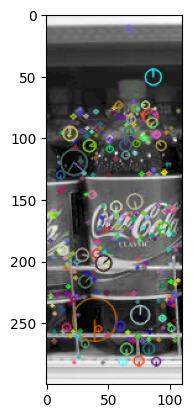

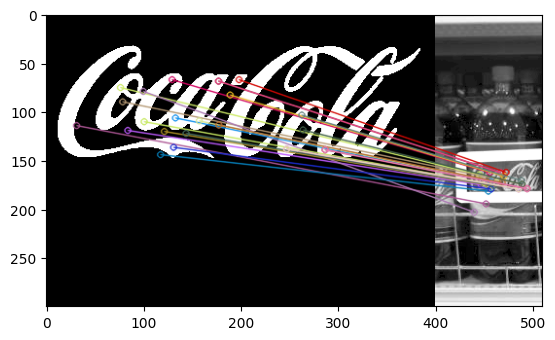

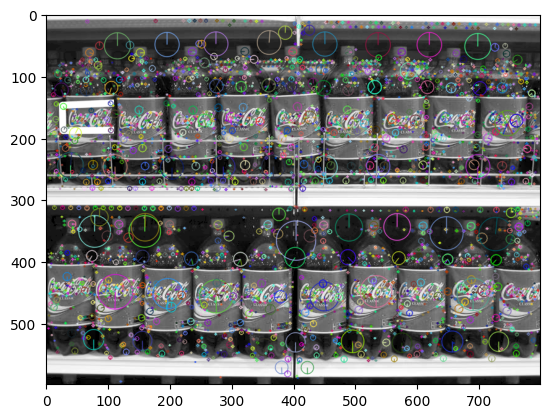

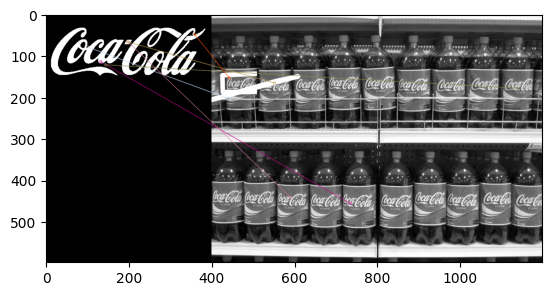

True

In [178]:
# Ejemplo con ORB
img1 = preproc_template_img(cv.imread('./template/pattern.png', cv.IMREAD_GRAYSCALE))
img2 = cv.imread('./images/coca_multi.png', cv.IMREAD_GRAYSCALE)
find_image(img1, img2[:300,:110])
find_image(img1, img2)

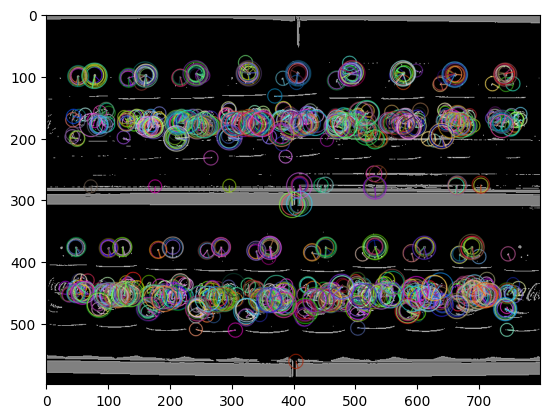

DBSCAN found 49 potential character clusters.
Cluster 0


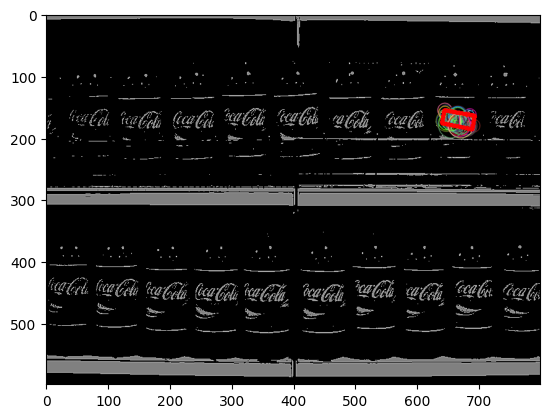

Cluster 1


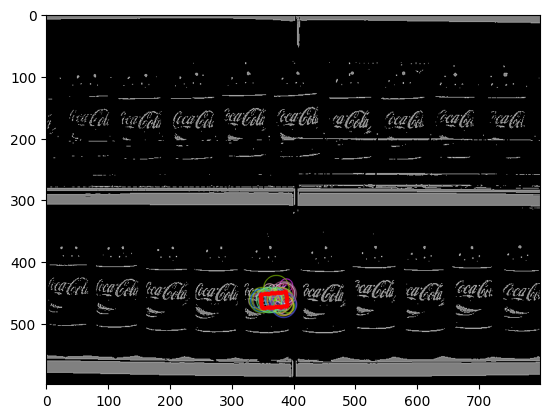

Cluster 2


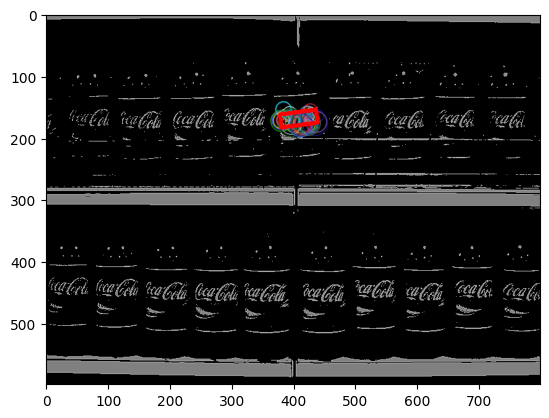

Cluster 3


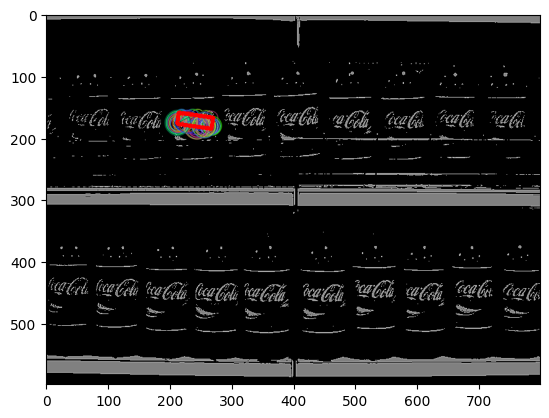

Cluster 4


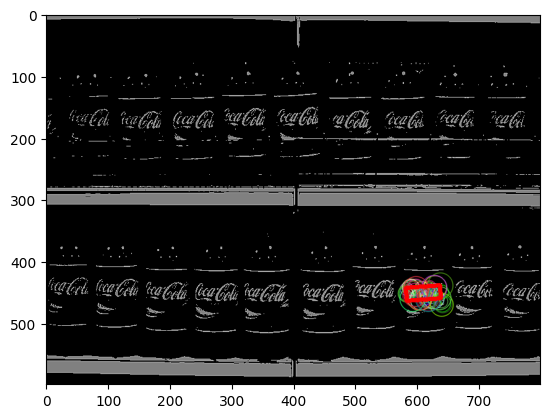

Cluster 5


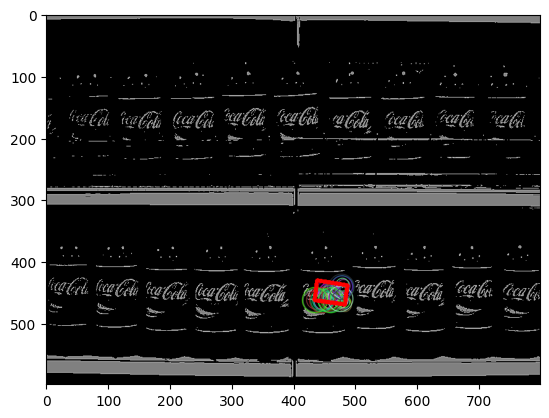

Cluster 6


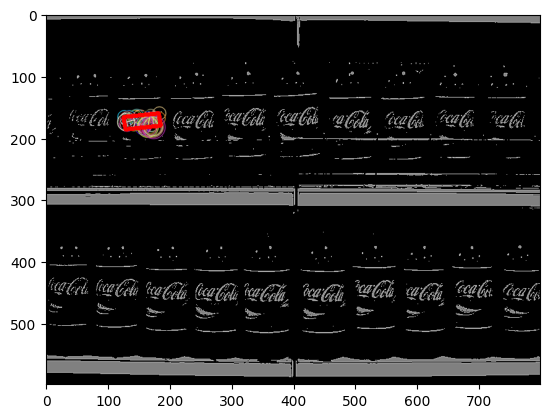

Cluster 7


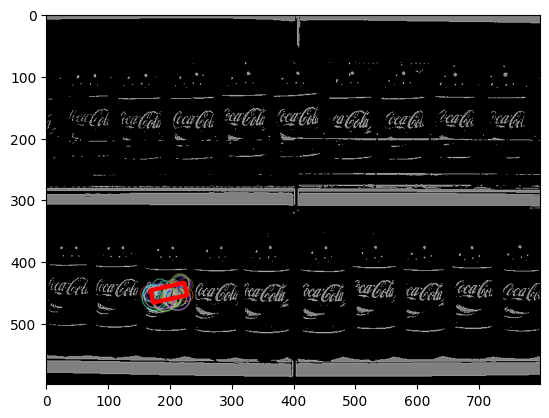

Cluster 8


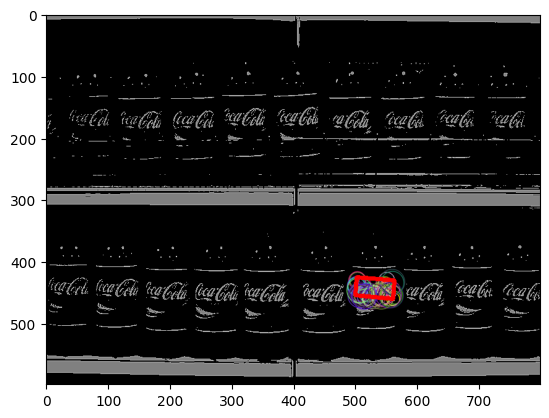

Cluster 9
Too few good matches
Cluster 10


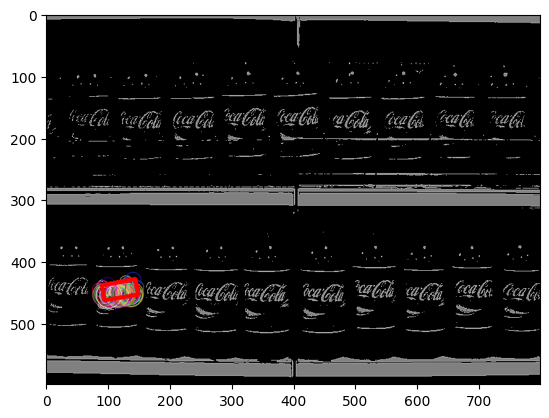

Cluster 11


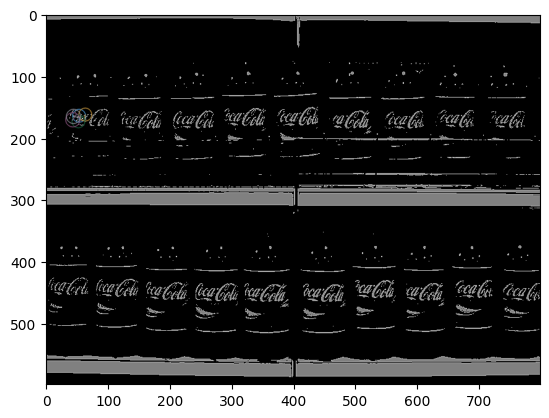

Cluster 12


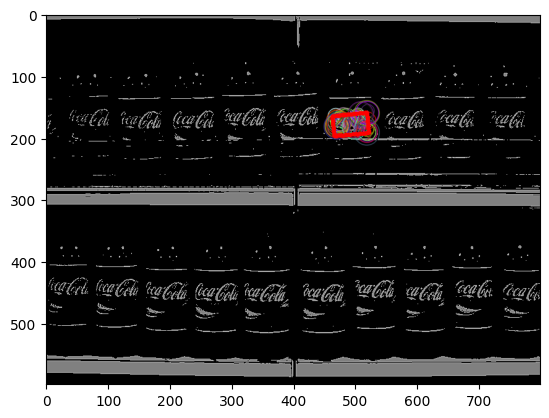

Cluster 13


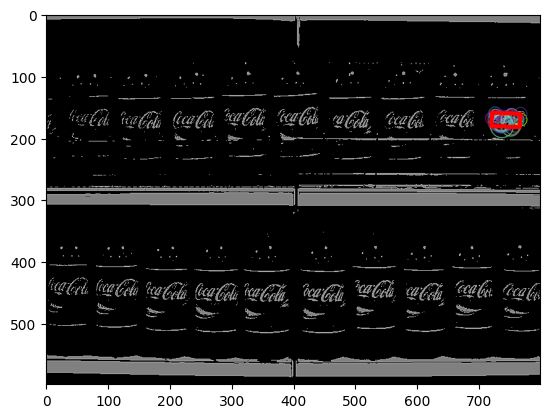

Cluster 14
Too few good matches
Cluster 15


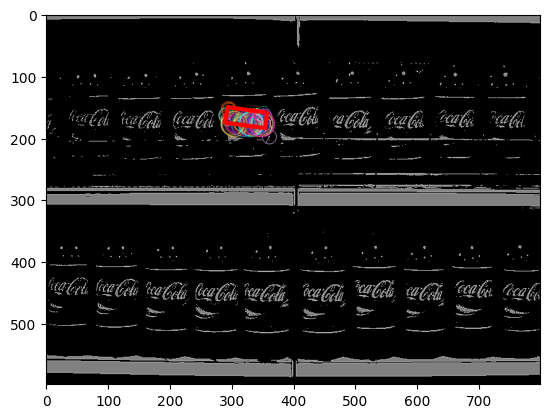

Cluster 16


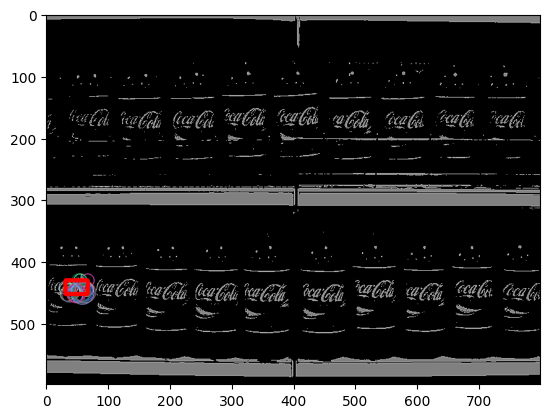

Cluster 17


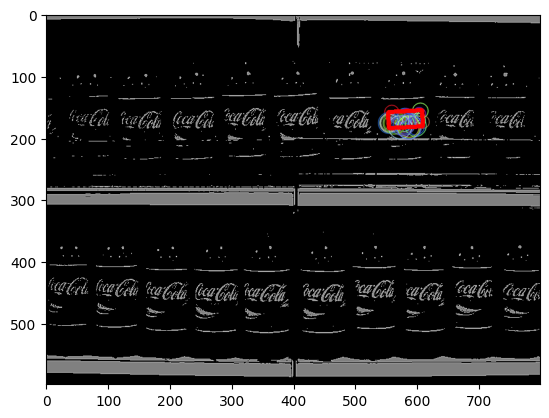

Cluster 18


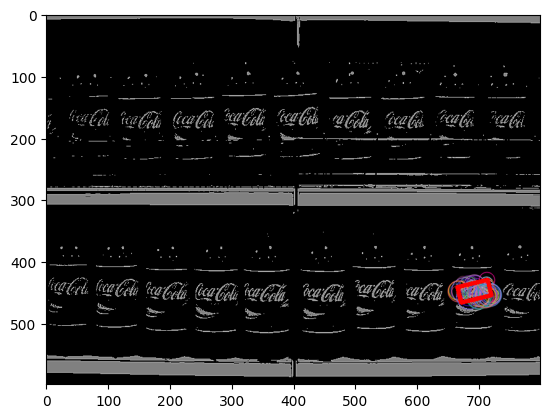

Cluster 19


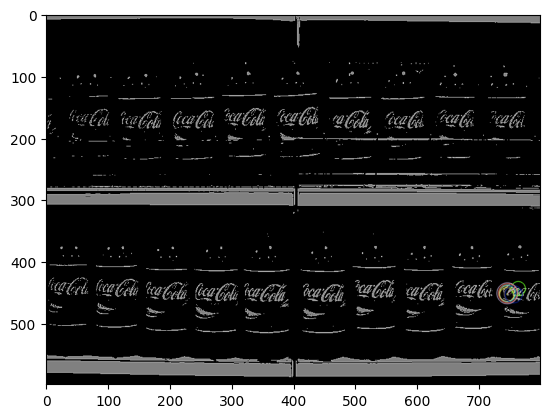

Cluster 20
Too few good matches
Cluster 21
Too few good matches
Cluster 22
Too few good matches
Cluster 23


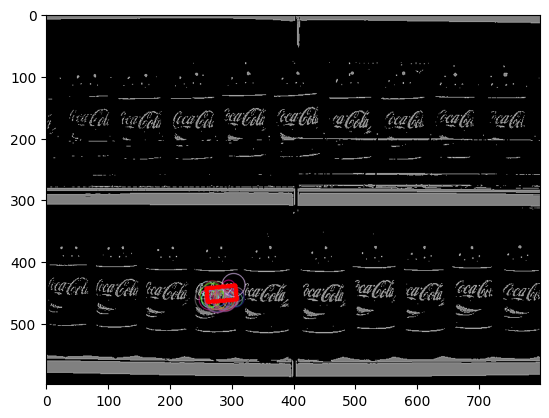

Cluster 24
Too few good matches
Cluster 25


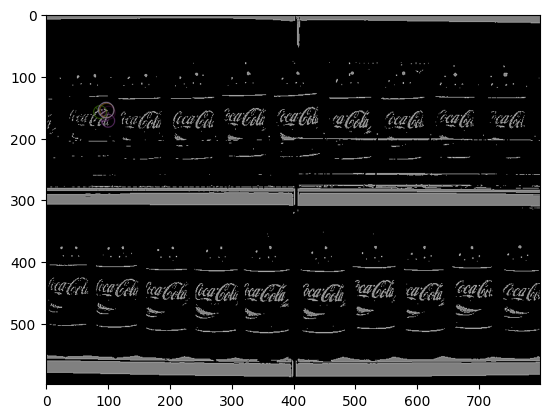

Cluster 26


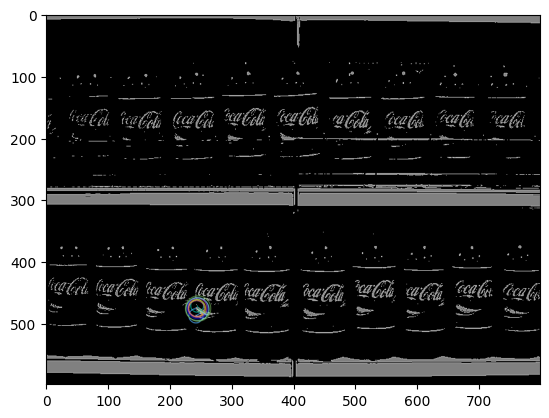

Cluster 27


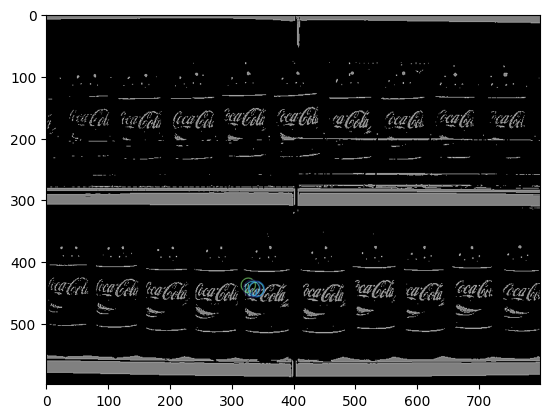

Cluster 28


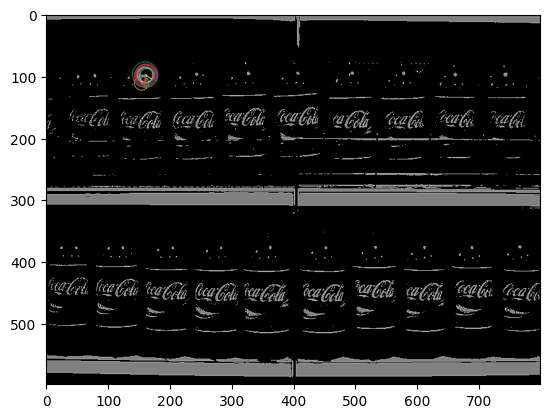

Cluster 29
Too few good matches
Cluster 30


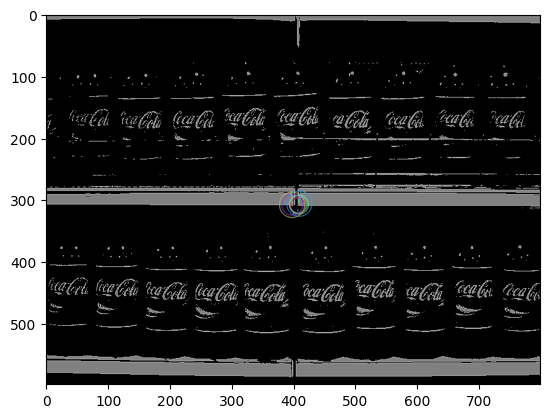

Cluster 31


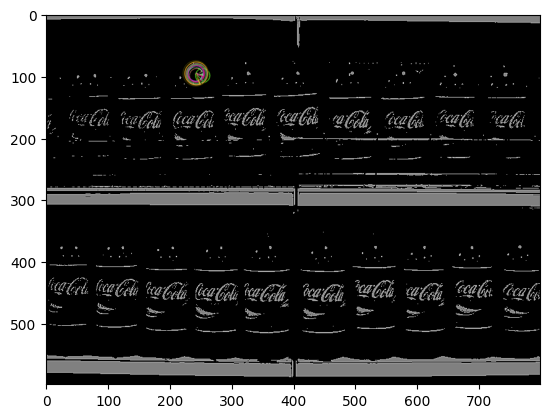

Cluster 32


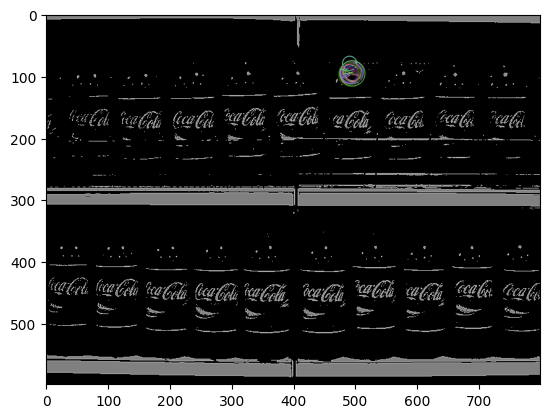

Cluster 33


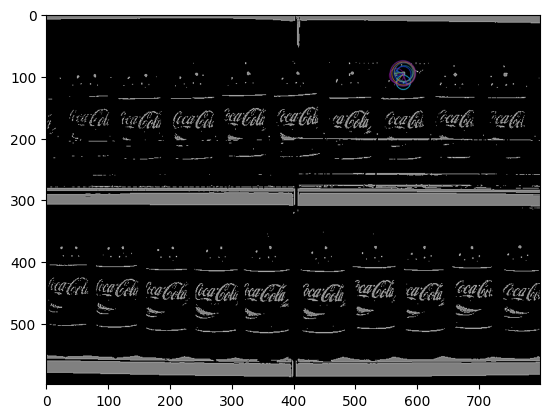

Cluster 34


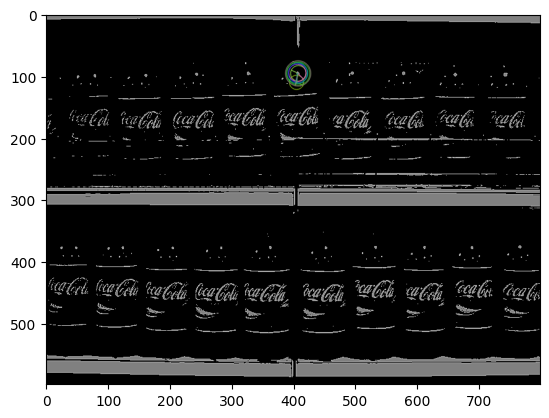

Cluster 35
Too few good matches
Cluster 36
Too few good matches
Cluster 37


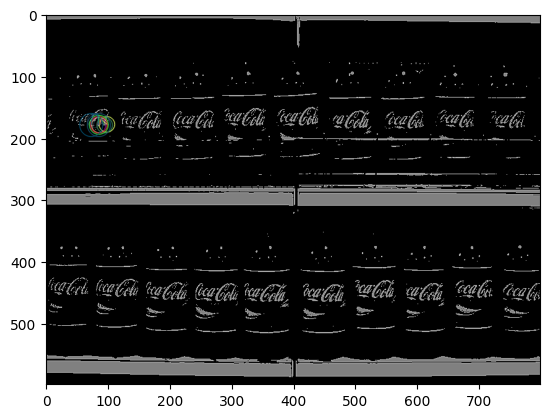

Cluster 38


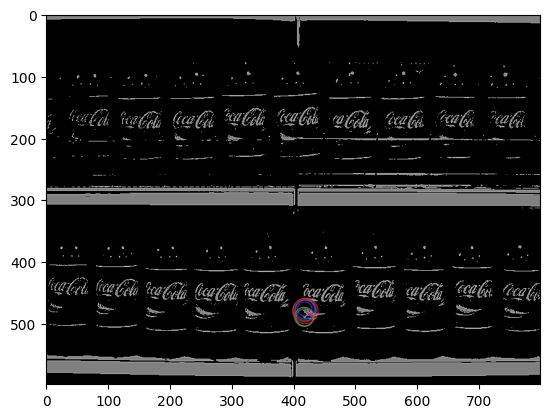

Cluster 39


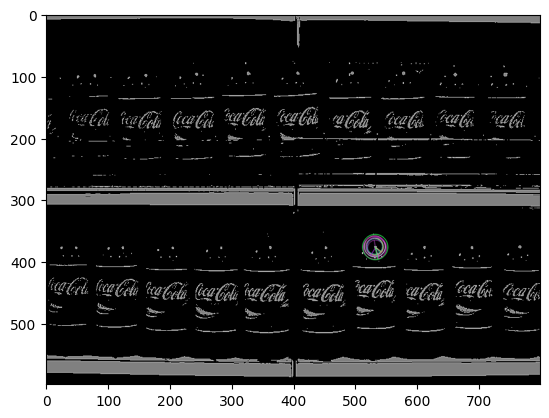

Cluster 40


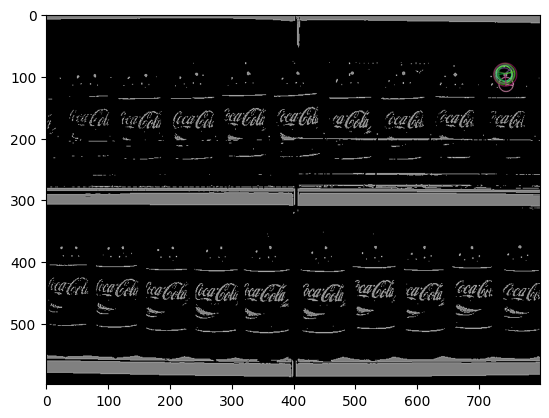

Cluster 41


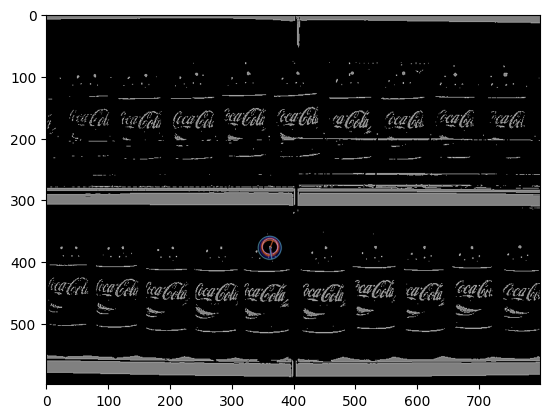

Cluster 42


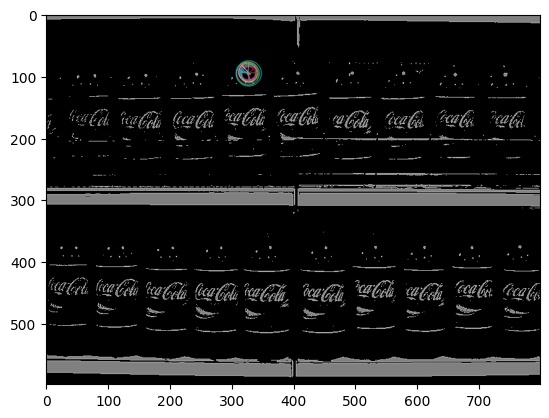

Cluster 43


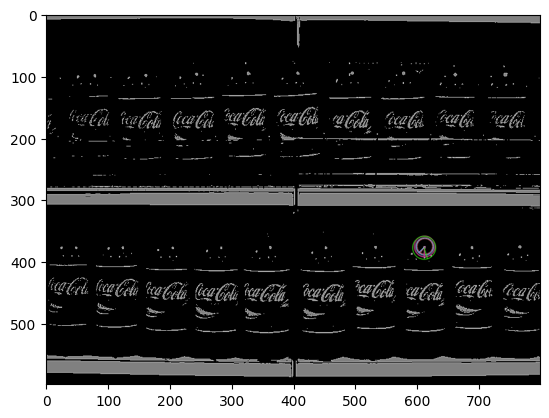

Cluster 44


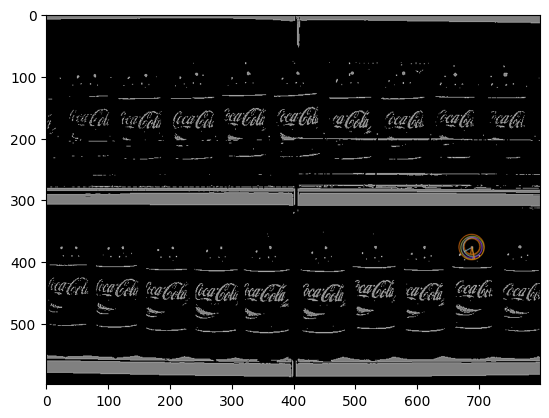

Cluster 45
Too few good matches
Cluster 46


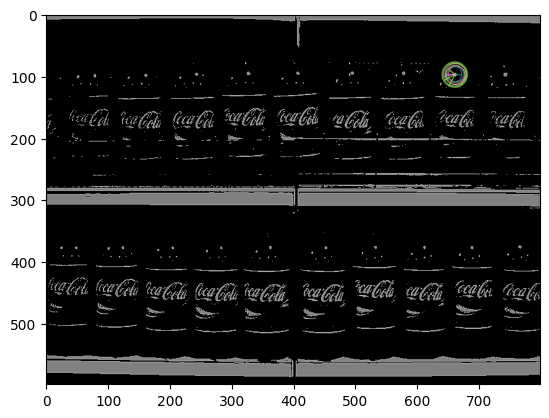

Cluster 47
Too few good matches
Cluster 48
Too few good matches
Cluster -1


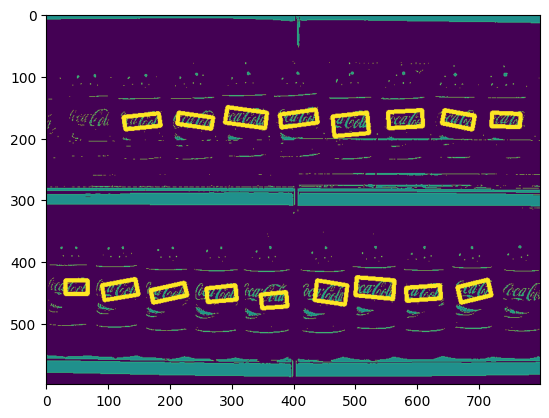

17

In [162]:
# Ejemplo con ORB
img1 = preproc_template_img(cv.imread('./template/pattern.png', cv.IMREAD_GRAYSCALE))
img2 = preproc_target_img(cv.imread('./images/coca_multi.png', cv.IMREAD_GRAYSCALE))
find_multi_image(img1, img2)

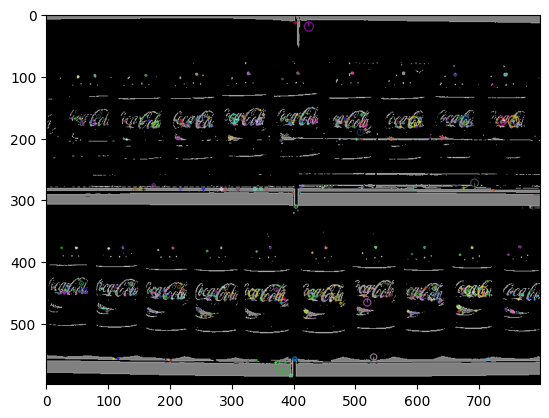

DBSCAN found 27 potential character clusters.
Cluster 0
Too few good matches
Cluster 1
Too few good matches
Cluster 2


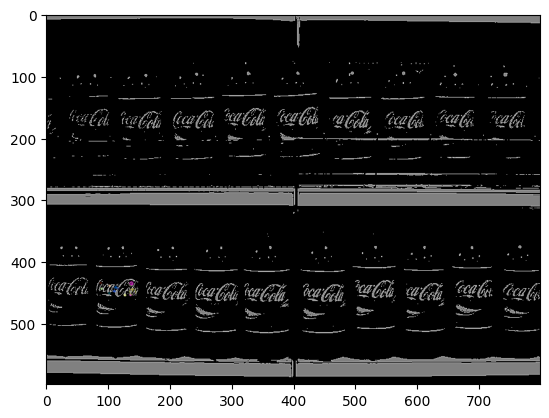

Cluster 3
Too few good matches
Cluster 4


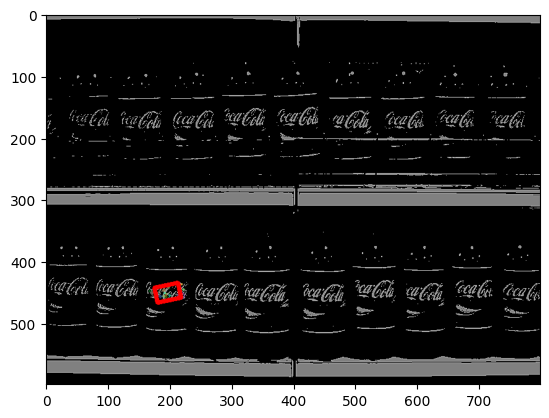

Cluster 5


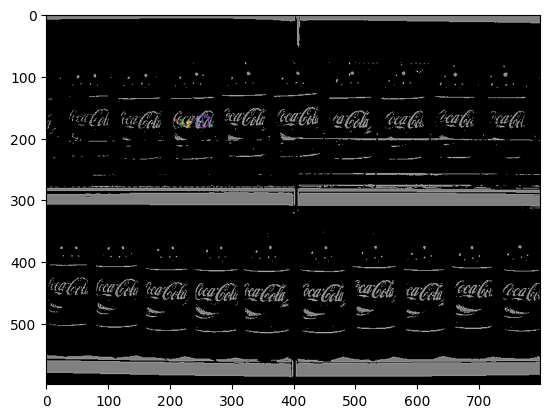

Cluster 6


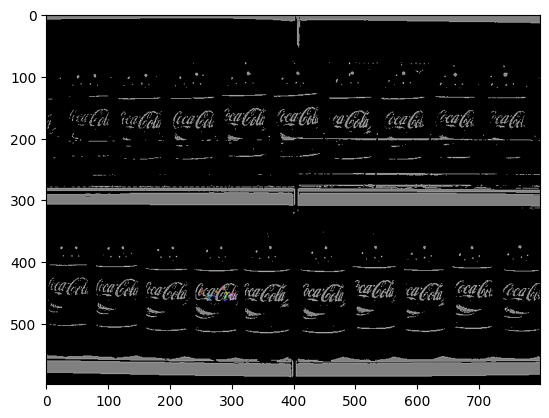

Cluster 7


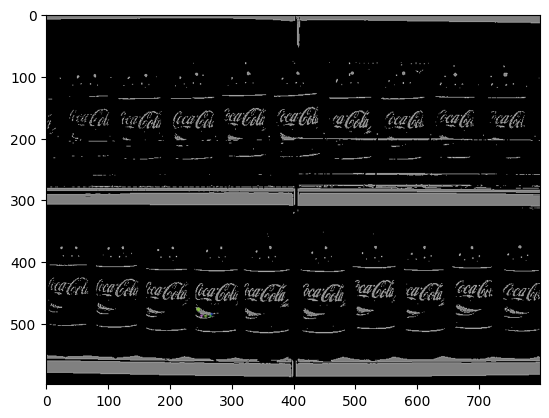

Cluster 8


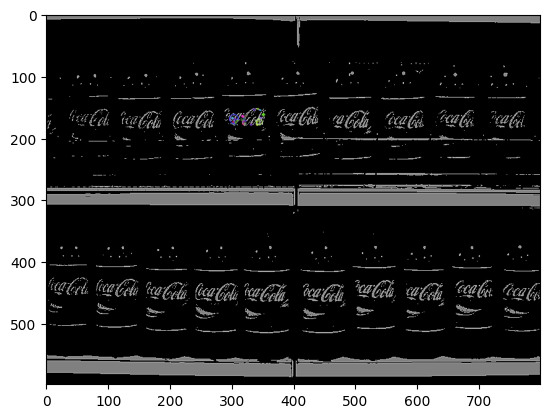

Cluster 9


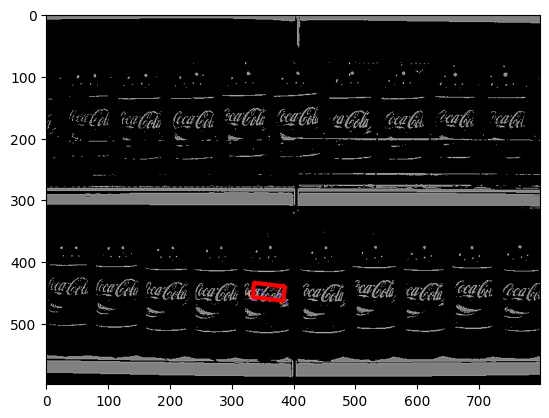

Cluster 10


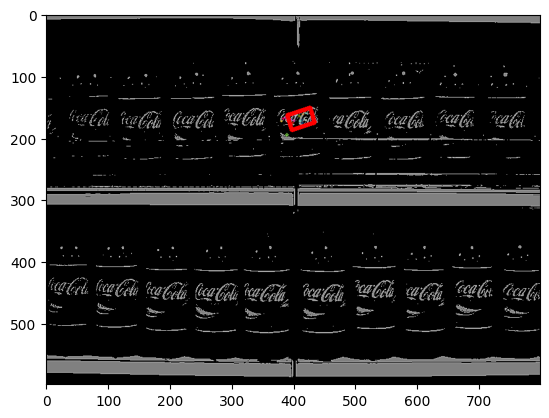

Cluster 11


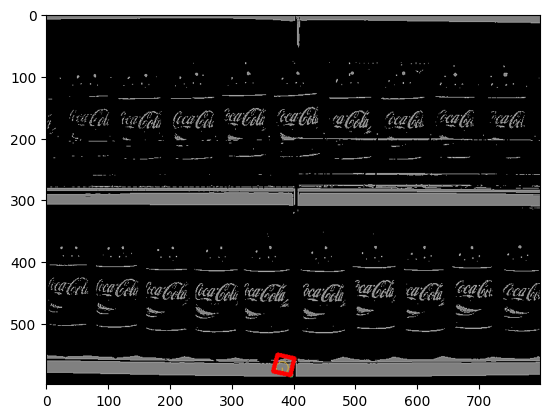

Cluster 12
Too few good matches
Cluster 13


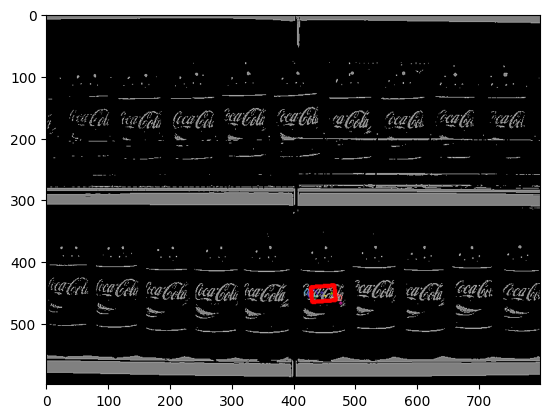

Cluster 14


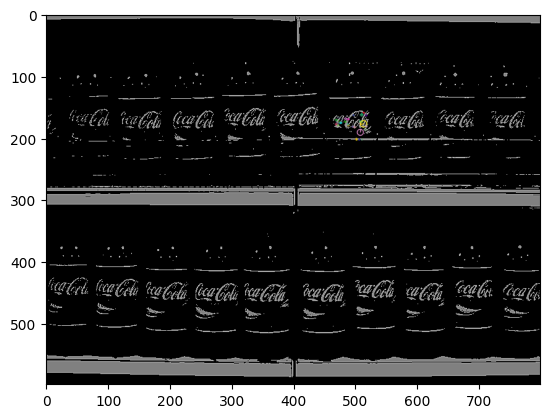

Cluster 15


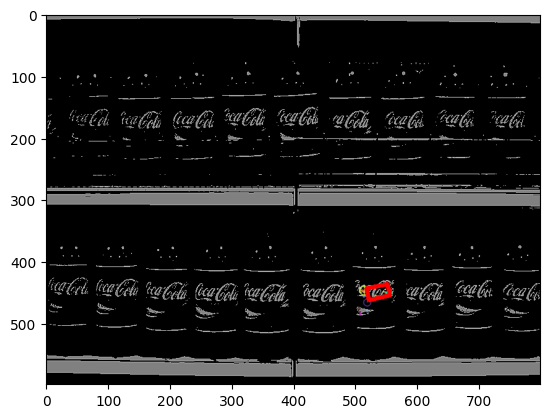

Cluster 16


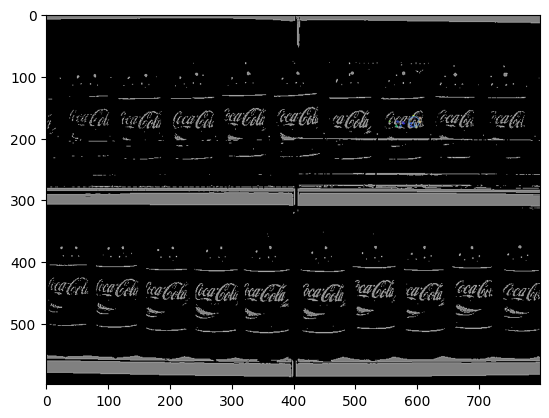

Cluster 17


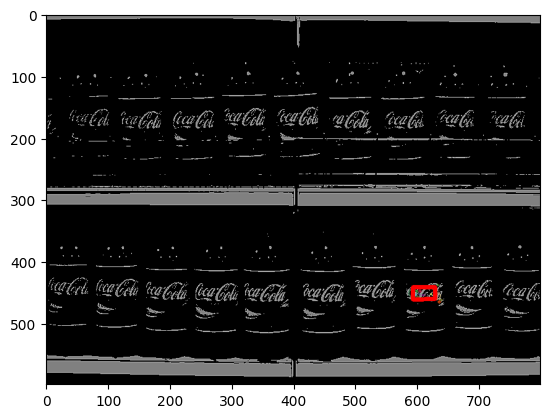

Cluster 18


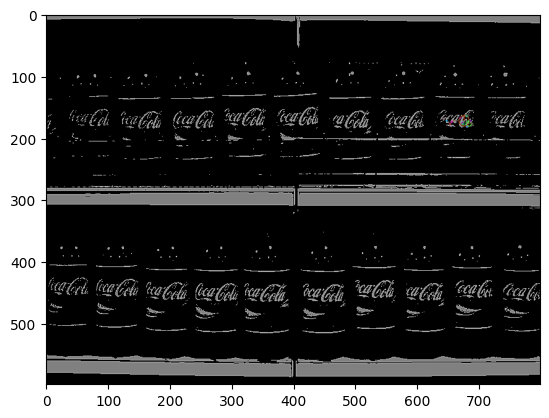

Cluster 19
Too few good matches
Cluster 20


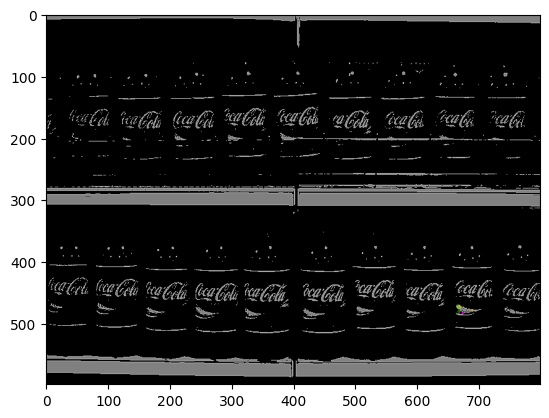

Cluster 21


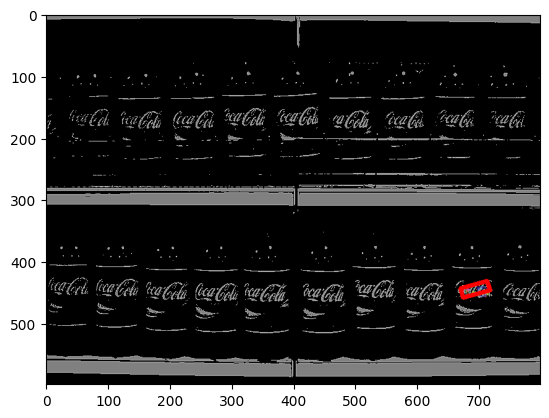

Cluster 22


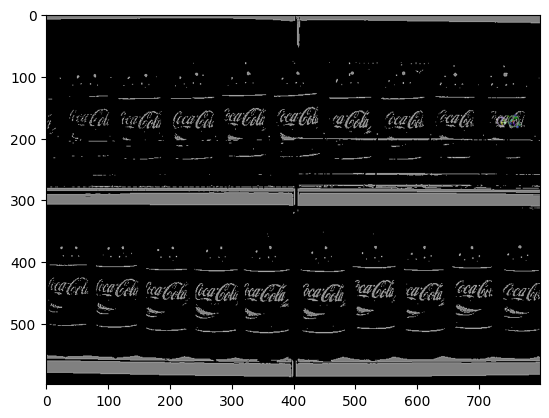

Cluster 23
Too few good matches
Cluster 24
Too few good matches
Cluster 25


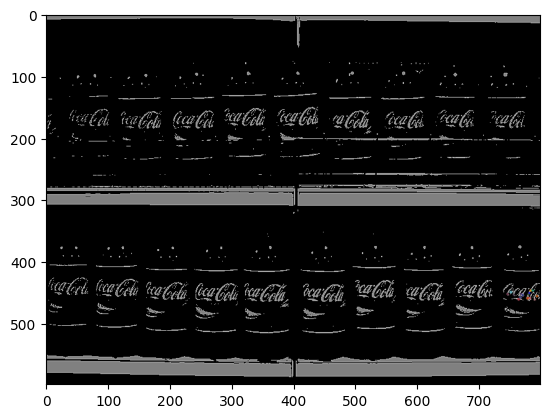

Cluster 26
Too few good matches
Cluster -1


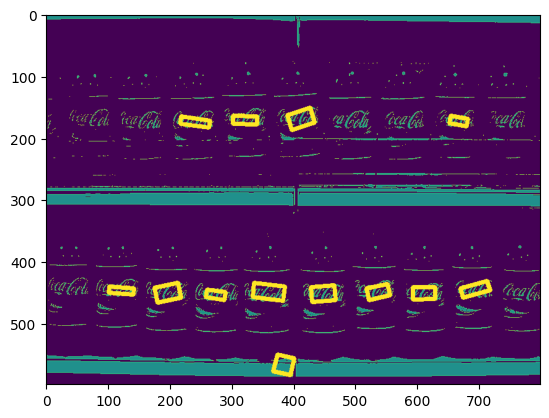

8

In [165]:
# Ejemplo con SIFT
find_multi_image_sift(img1, img2)


# Resultado final con matching simple

Analyzing image COCA-COLA-LOGO.jpg.
Trying single pattern search COCA-COLA-LOGO.jpg.


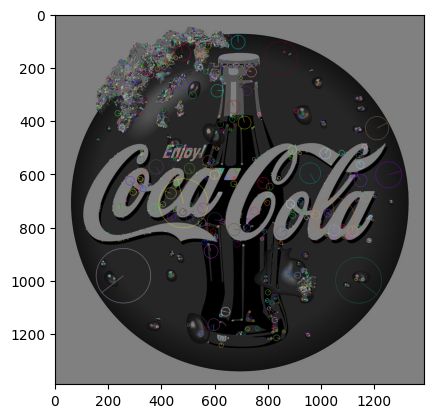

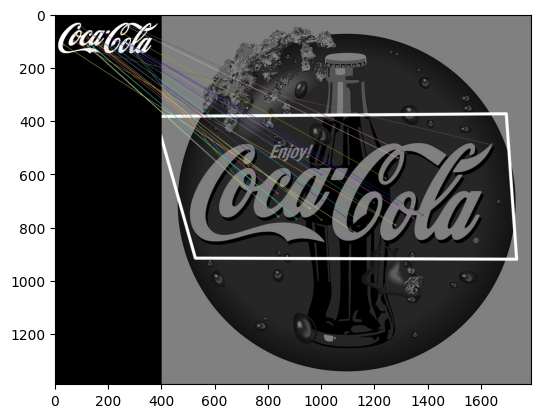

Analyzing image coca_logo_1.png.
Trying single pattern search coca_logo_1.png.


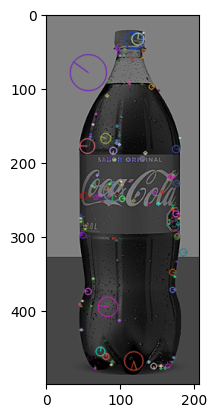

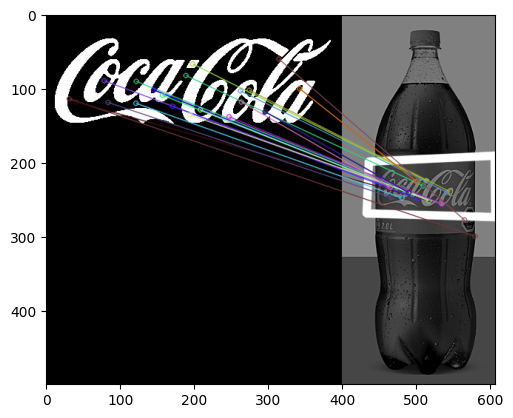

Analyzing image coca_logo_2.png.
Trying single pattern search coca_logo_2.png.


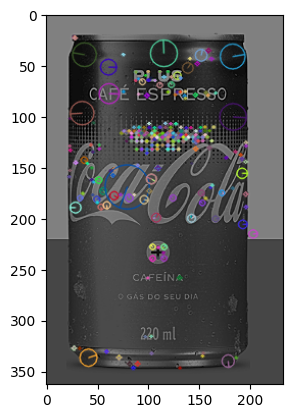

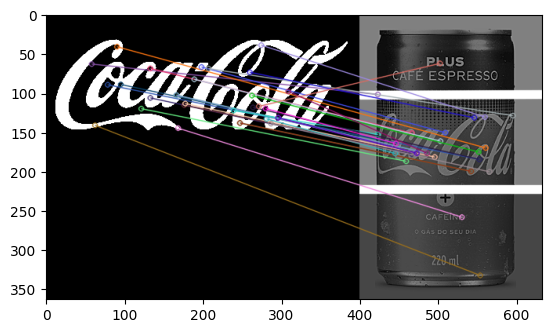

Analyzing image coca_multi.png.
Trying single pattern search coca_multi.png.


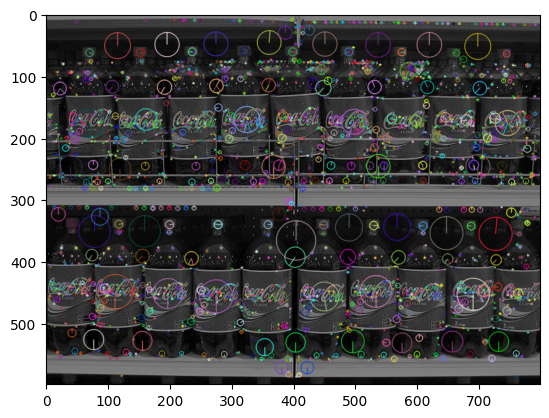

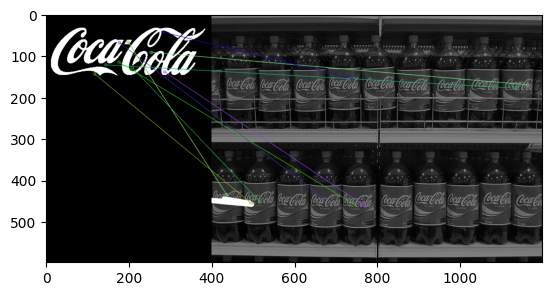

Analyzing image coca_retro_1.png.
Trying single pattern search coca_retro_1.png.
too few good points
Single pattern search failed coca_retro_1.png.
Flipping template.
Trying single pattern search coca_retro_1.png.


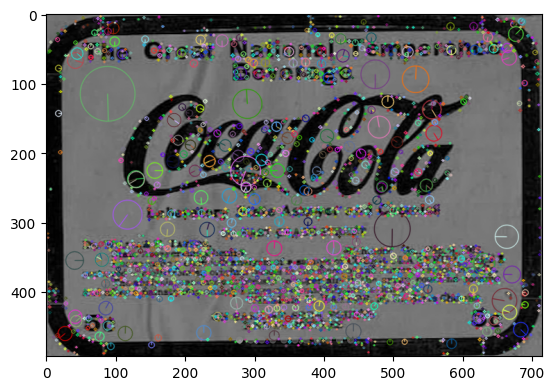

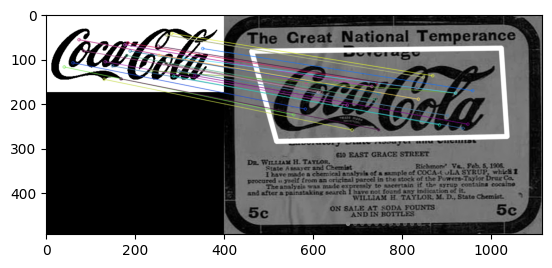

Analyzing image coca_retro_2.png.
Trying single pattern search coca_retro_2.png.


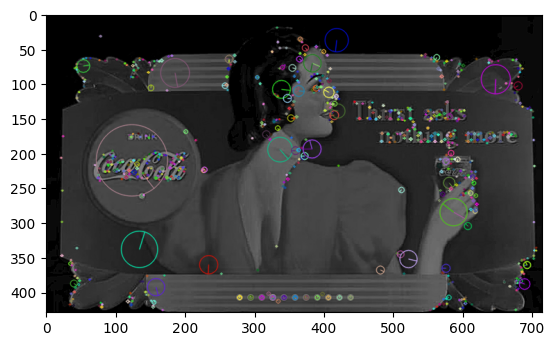

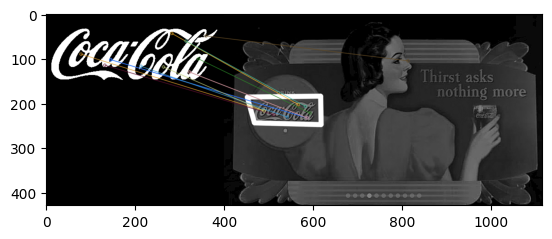

Analyzing image logo_1.png.
Trying single pattern search logo_1.png.


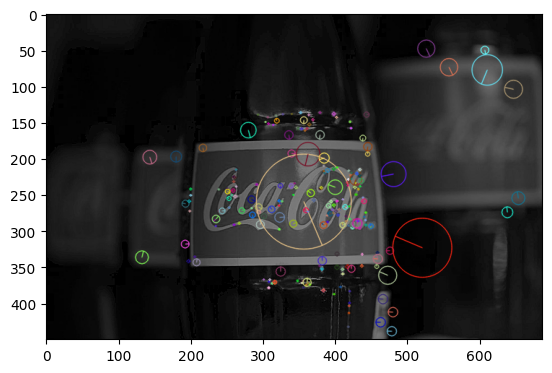

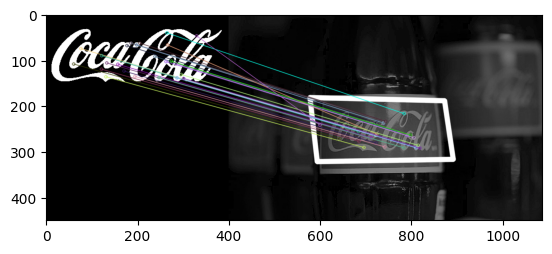

In [170]:
images = filter(lambda filename: 'png' in  filename or 'jpg' in  filename, os.listdir('./images/'))
img1 = preproc_template_img(cv.imread('./template/pattern.png', cv.IMREAD_GRAYSCALE))
for image in images:
    print(f'Analyzing image {image}.')
    img = cv.imread('./images/' + image, cv.IMREAD_GRAYSCALE)
    img = sharpenning(img)
    
    print(f'Trying single pattern search {image}.')
    drawn = find_image(img1, img)
    if drawn:
        continue
    print(f'Single pattern search failed {image}.')
    
    print(f'Flipping template.')
    print(f'Trying single pattern search {image}.')
    drawn = find_image(cv.bitwise_not(img1), img)


    if not drawn:
        print(f'FAILURE: Could not find pattern for image {image}.')

# Resultado final con matching simple

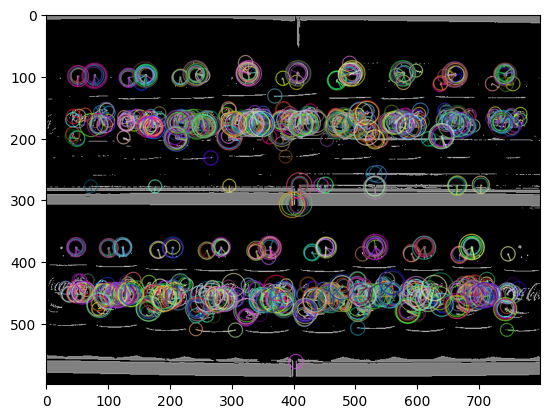

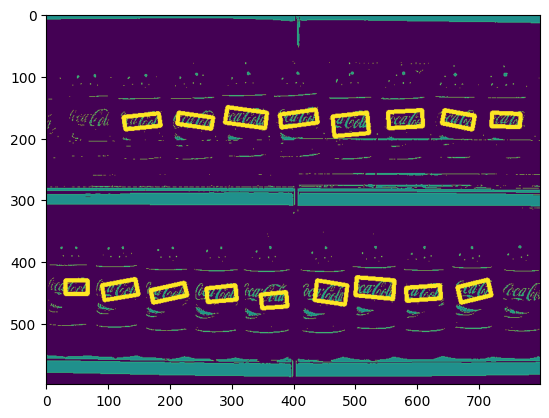

17

In [166]:
img = cv.imread('./images/coca_multi.png', cv.IMREAD_GRAYSCALE)
img = preproc_target_img(img)
find_multi_image(img1, img, debug=False)
